## Conclusion de l'EDA

Les variables suivantes expliquent une part importante de la variabilité :

* La température (et donc les saisons).

* L'heure de la journée.

* Le type de jour (semaine/week-end).

* Les vacances et les jours fériés.

* Les jours TEMPO.

In [67]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
df = pd.read_csv("final_df.csv", parse_dates = ["Date"], low_memory = False )
df['Date'] = pd.to_datetime(df['Date'])

## Preprocessing

### Cropping and cleaning

In [69]:
## Remove useless variables ##

cols_to_drop_pre = [
    'Périmètre','Nature',
    'Fioul','Charbon','Gaz','Nucléaire','Eolien','Solaire','Hydraulique','Pompage','Bioénergies','Ech. physiques',
    'Fioul - TAC','Fioul - Cogén.','Fioul - Autres',
    'Gaz - TAC','Gaz - Cogén.','Gaz - CCG','Gaz - Autres',
    'Hydraulique - Fil de l?eau + éclusée','Hydraulique - Lacs','Hydraulique - STEP turbinage',
    'Bioénergies - Déchets','Bioénergies - Biomasse','Bioénergies - Biogaz',
    ' Stockage batterie','Déstockage batterie',
    'Eolien terrestre','Eolien offshore',
    'Ech. comm. Angleterre','Ech. comm. Espagne','Ech. comm. Italie',
    'Ech. comm. Suisse','Ech. comm. Allemagne-Belgique',
    'Taux de Co2'
]

cols_to_drop_pre = [c for c in cols_to_drop_pre if c in df.columns]
df = df.drop(columns=cols_to_drop_pre)

In [70]:
## Remove the lines before and after the first consumption day ##

df['DateTime'] = pd.to_datetime(
    df['Date'].dt.date.astype(str) + ' ' + df['Heures'].astype(str),
    format='%Y-%m-%d %H:%M',
    errors='coerce'
)

df = df.set_index('DateTime').sort_index()

valid = df['Consommation'].dropna()
min_ts = valid.index.min()
max_ts = valid.index.max()

# For a D + 1 prediction, we can afford to cut the data after the last day of consumption. 
#To produce true forecasts up to 2030 using holiday and vacation data up to 2030, we would need to simulate the other variables up to 2030.
df = df.loc[min_ts : max_ts]

df = df.reset_index(drop = True)

In [71]:
## Standardize to a 30-minute consumption regime ##

df['Date'] = pd.to_datetime(df['Date'])
df['Heures'] = df['Heures'].astype(str)

df = df.dropna(subset=['Heures'])

df['DateTime'] = pd.to_datetime(
    df['Date'].dt.date.astype(str) + ' ' + df['Heures'],
    format = '%Y-%m-%d %H:%M',
    errors = 'coerce'    # transforms invalid formats into NaT
)

df = df.dropna(subset = ['DateTime'])

df = df.set_index('DateTime')
df = df.sort_index()

df = df[df.index.minute.isin([0, 30])].copy()

df = df.reset_index(drop = True)

In [491]:
## Handle outliers ?

### Data spliting

In [72]:
df = df.set_index('Date')
df = df.sort_index()

# Dynamic boundaries : 1-year test and 1-year validation
last_date  = df.index.max()
delta_year = pd.DateOffset(years = 1)

# pd.Timedelta (days = 1) to shift the borders by one day
test_start  = last_date - delta_year + pd.Timedelta(days = 1)
valid_start = test_start  - delta_year
train_end   = valid_start - pd.Timedelta(days = 1)

train = df.loc[:train_end]
valid = df.loc[valid_start:test_start - pd.Timedelta(days = 1)]
test  = df.loc[test_start:]

df = df.reset_index()

### Features engineering

**Features à ajouter**

* *HDD et CDD* -> "Heating Degree Days" et "Cooling Degree Days" sont des indicateurs très utilisés en énergétique des batîments qui traduisent en chiffres la « rigueur » d’un climat vis-à-vis des besoins de chauffage et de climatisation.
* *hour_sin et hour_cos* -> On a vu avec l'EDA que la consomation électrique varie cycliquement au cours de la journée. Ces deux features permettent de représenter cela.
* *day_of_week* -> On a vu avec l'EDA qu'en moyenne, la consommation le week-end est ~11 % plus basse qu’en semaine.
* *lag_24h* -> Consommation exactement 24 heures avant, à la même heure qu’aujourd’hui. Utile parceque la demande électrique à une heure donnée ressemble souvent beaucoup à celle de la veille à la même heure.
* *roll_mean_7d* -> Moyenne des consommations des 7 jours précédents, toujours à la même heure. Cela donne la tendance hebdomadaire, cad si cette heure-ci a été globalement haute ou basse en terme de conso sur la dernière semaine.
* *resid_j-1* -> Erreur de la prévision “naïve” faite la veille (J-1) pour ce même créneau au jour J. Peut permettre d'informer le modèle de la performance du benchmark : s’il sous- ou sur-prévoit, le modèle peut ajuster.

In [73]:
## Feature engigneering class ## 

class FeatureEngineering(BaseEstimator, TransformerMixin):
    
    def __init__(self, T_ref = 18.0, freq_minutes = 30):
        # 18°C is the average temperature above which an “average” building needs neither heating (sufficient internal input) nor air conditioning.
        self.T_ref = T_ref
        # We checked in various_check that each day of the dataset was divided into quarter hours.
        self.steps_per_day = int(24 * 60 / freq_minutes)

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        
        df_fe = X.copy()

        # 1) Hour cyclic
        df_fe = df_fe.reset_index()
        df_fe.index = pd.to_datetime(df_fe['Date'].dt.date.astype(str) + ' ' + df_fe['Heures'].astype(str), format = '%Y-%m-%d %H:%M')
        df_fe = df_fe.sort_index()
        hours = df_fe.index.hour + df_fe.index.minute / 60.0
        df_fe['hour_sin'] = np.sin(2 * np.pi * hours / 24)
        df_fe['hour_cos'] = np.cos(2 * np.pi * hours / 24)
        df_fe = df_fe.reset_index(drop = True)

        # 2) day_of_week
        df_fe = df_fe.set_index('Date')
        df_fe['day_of_week'] = df_fe.index.dayofweek

        # 3) HDD & CDD
        df_fe['HDD'] = (self.T_ref - df_fe['Avg_temp_mean']).clip(lower=0)
        df_fe['CDD'] = (df_fe['Avg_temp_mean'] - self.T_ref).clip(lower=0)

        # 4) lag_24h (24h = steps_per_day lignes)
        df_fe['lag_24h'] = df_fe['Consommation'].shift(periods = self.steps_per_day)

        # 5) roll_mean_7d (rolling window of 7 days on lag_24h)
        df_fe['roll_mean_7d'] = (
            df_fe
              .groupby(df_fe.index.time)['lag_24h']
              .transform(lambda s: s.rolling(window=7).mean())
        )

        # 6) resid_j-1
        df_fe['resid_j-1'] = df_fe['Consommation'] - df_fe['Prévision J-1']

        return df_fe

In [74]:
## Apply features engineering to the subsets ## 

fe    = FeatureEngineering()

train_fe        = fe.fit_transform(train)
train_fe_clean  = train_fe.dropna(subset = ['lag_24h','roll_mean_7d'])
y_train_resid   = train_fe_clean['Consommation'] - train_fe_clean['Prévision J']
X_train_resid   = train_fe_clean.drop(columns = [
    'Heures','Consommation','Prévision J','Prévision J-1',
    'Avg_temp_min','Avg_temp_max','Avg_temp_mean'
])

valid_fe       = fe.transform(valid)                                    
valid_fe_clean = valid_fe.dropna(subset = ['lag_24h','roll_mean_7d'])      
y_valid_resid  = valid_fe_clean['Consommation'] - valid_fe_clean['Prévision J']
X_valid_resid  = valid_fe_clean.drop( columns = [
    'Heures','Consommation','Prévision J','Prévision J-1',
    'Avg_temp_min','Avg_temp_max','Avg_temp_mean'
]) 

test_fe        = fe.transform(test)
test_fe_clean  = test_fe.dropna(subset = ['lag_24h','roll_mean_7d'])
y_test_resid   = test_fe_clean['Consommation'] - test_fe_clean['Prévision J']
X_test_resid   = test_fe_clean.drop(columns = [
    'Heures','Consommation','Prévision J','Prévision J-1',
    'Avg_temp_min','Avg_temp_max','Avg_temp_mean'
])

In [75]:
## Apply feature cleaning / imputing / scaling to the subsets ##

# Impute missing temperatures + missing flag. 
# Idealy inspects the proportion and seasonality of the missing: if NaN are massive in summer, the imputation will bias the summer consumption.
temperature_imputer = SimpleImputer(strategy = 'mean', add_indicator = True) # Add a feature to take into account missing values

# Impute TEMPO with BLUE, which is the more common day
tempo_imputer = Pipeline([
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'BLEU')),
    ('ohe', OneHotEncoder(drop = 'first')) # Drop the first modality to avoid linear collinearity (dummy-trap).
])

numerical_feats = ['resid_j-1','hour_sin','hour_cos','lag_24h','roll_mean_7d']
categorial_feats = ['day_of_week']
binary_feats = ['Bank holidays','School holidays']

# Cleaning and scaling trasnformer
ImputingAndScaling = ColumnTransformer(
    [
        # Impute temperature
        ('temp', temperature_imputer, ['HDD','CDD']),
        # Impute TEMPO
        ('tempo', tempo_imputer, ['Type de jour TEMPO']),
        # Scale continuous numerical variables between 0 and 1
        ('num', StandardScaler(), numerical_feats),
        # One-hot encoding of categorical variables (Day of week)
        ('cat', OneHotEncoder(drop = 'first'), categorial_feats),
        # Binary indicators (Bank holidays, School holidays) are kept as they are.
    ],
    remainder = 'passthrough',
    force_int_remainder_cols = False # Passthrough columns referenced by name (to avoid the warning)
)

prep = ImputingAndScaling
X_train_pre = prep.fit_transform(X_train_resid)
X_valid_pre = prep.transform(X_valid_resid)
assert not np.isnan(X_valid_pre).any()
X_test_pre  = prep.transform(X_test_resid)
assert not np.isnan(X_test_pre).any()

In [89]:
## Construction of the model ##

# Boosting tree-based algorithm naturally capture non-linearities and interactions, handle mixed data well, and are fast to train and predict on large volumes.
# XGBRegressor or LightGBM ?

xgb = XGBRegressor(
    n_estimators = 500, # Number of trees (boosting rounds) built sequentially. The more trees, the more complex the model. 500 seems to be a classic compromise.
    learning_rate = 0.05, # 0.05 is a common compromise: low enough to stabilize the training, high enough for 500 tree to be sufficient.
    max_depth = 7, # Maximum depth allowed for each tree. 7 let the model model interactions up to a certain order without overlearning.
    objective = 'reg:squarederror', # loss function that the model will minimize during the learning.
    random_state = 42, # Random seed for reproducible results 
    verbosity = 1,
    eval_metric=['rmse','mae'],
    early_stopping_rounds = 50 # Abitrary for the moment
)

### Training

In [90]:
## Training ##

xgb.fit(
    X_train_pre, y_train_resid,
    eval_set = [(X_train_pre, y_train_resid),
              (X_valid_pre, y_valid_resid)],
    verbose = False
)
print("Training completed !")

resid_pred_valid = xgb.predict(X_valid_pre)
cons_pred_valid  = valid_fe_clean['Prévision J'] + resid_pred_valid
print("Prediction on valid set completed !")

resid_pred_test  = xgb.predict(X_test_pre)
cons_pred_test   = test_fe_clean['Prévision J'] + resid_pred_test
print("Prediction on test set completed !")

Training completed !
Prediction on valid set completed !
Prediction on test set completed !


### Results

VALID → RMSE: 804.39, MAE: 468.53
TEST → RMSE: 572.47, MAE: 442.47


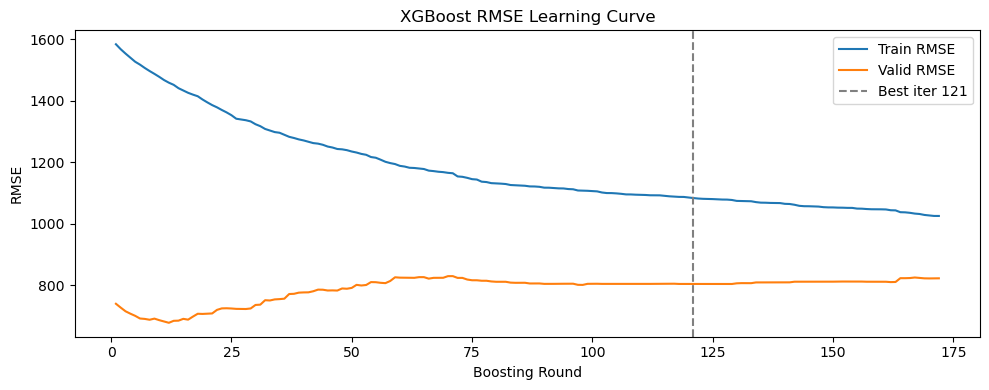

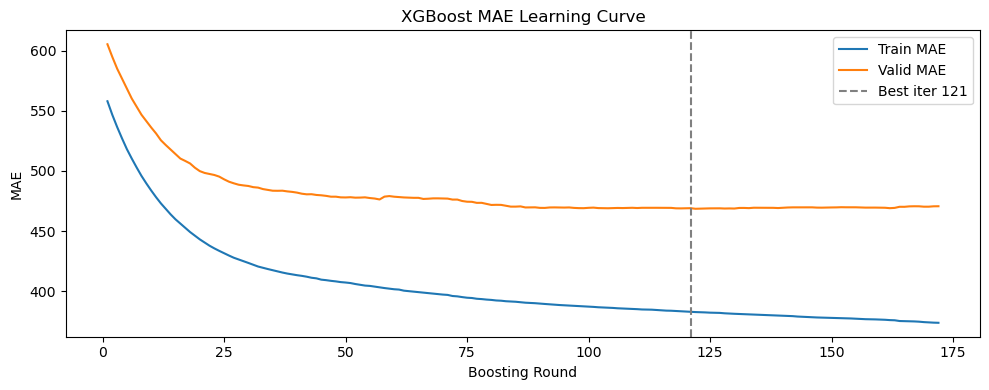

In [92]:
def print_metrics(y_true, y_pred, label):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"{label} → RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# VALIDATION
print_metrics(
    valid_fe_clean['Consommation'],
    cons_pred_valid,
    "VALID"
)

# TEST
print_metrics(
    test_fe_clean['Consommation'],
    cons_pred_test,
    "TEST"
)

result = xgb.evals_result()
epochs = range(1, len(res['validation_0']['rmse']) + 1)

# RMSE LEARNING CURVES
plt.figure(figsize = (10,4))
plt.plot(epochs, result['validation_0']['rmse'], label = 'Train RMSE')
plt.plot(epochs, result['validation_1']['rmse'], label = 'Valid RMSE')
plt.axvline(xgb.best_iteration, color = 'gray', linestyle = '--', label = f'Best iter {xgb.best_iteration}')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE Learning Curve')
plt.legend()
plt.tight_layout()
plt.show()

# MAE LEARNING CURVES
plt.figure(figsize = (10,4))
plt.plot(epochs, result['validation_0']['mae'], label = 'Train MAE')
plt.plot(epochs, result['validation_1']['mae'], label = 'Valid MAE')
plt.axvline(xgb.best_iteration, color = 'gray', linestyle = '--', label = f'Best iter {xgb.best_iteration}')
plt.xlabel('Boosting Round')
plt.ylabel('MAE')
plt.title('XGBoost MAE Learning Curve')
plt.legend()
plt.tight_layout()
plt.show()

**Résultats** :

* Les erreurs sont dans les normes d'une prévision de charge électrique à J+1 définies par les opérateurs de réseau (RTE) et la littérature scientifique (MAE ≃ 1%, RMSE jusqu'à 2%).
* Le gain sur le sous-ensemble de test montre peut-être un problème légèrement « trop facile » ou un léger sur-apprentissage sur 2023.

* **Learning curves** :  
  - Phase initiale (rounds 0–10) : forte baisse de l’erreur sur train et validation (underfitting réduit).  
  - Rounds 10–60 : la validation RMSE/MAE remonte alors que le train continue de baisser (sur-apprentissage modéré).  
  - Au-delà, la courbe de validation se stabilise autour de l’itération optimale (~ 121).  
  → Suggestion : réduire l’early_stopping_rounds (10–20 rounds) ou renforcer la régularisation (max_depth plus faible, reg_lambda/alpha plus forts) pour limiter ce sur-apprentissage.

**Pour aller plus loin** :

* Rolling CV -> faire plusieurs découpages temporels (2021 vs 2022, 2022 vs 2023...) pour obtenir une estimation plus robuste de la variance du modèle ?

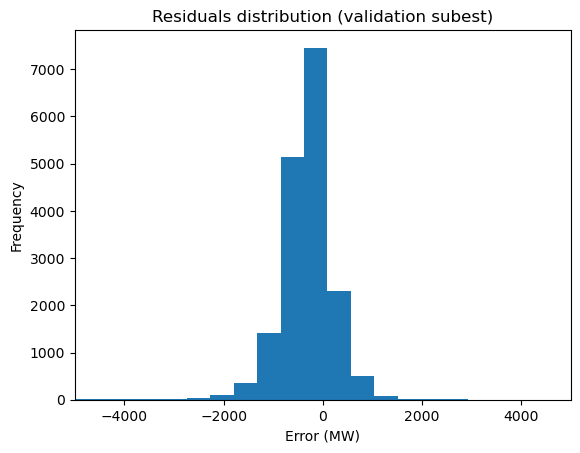

Residuals mean : -331.9813694482347 — Median : -281.49267959594727
t = -59.96, p-value = 0.000e+00
Cohen’s d = -0.453  (effect size)


In [80]:
## Residual analysis ##

resid_valid = valid_fe_clean['Consommation'] - cons_pred_valid

plt.hist(resid_valid, bins = 50)
plt.xlim(-5000, 5000)
plt.title("Residuals distribution (validation subest)")
plt.xlabel("Error (MW)")
plt.ylabel("Frequency")
plt.show()

resid_mean   = resid_valid.mean()
resid_median = resid_valid.median()
print("Residuals mean :", resid_mean, "— Median :", resid_median)

# H0 : mean = 0
t_stat, p_value = ttest_1samp(resid_valid, popmean = 0)
print(f"t = {t_stat:.2f}, p-value = {p_value:.3e}")

# Cohen's d for one-sample
resid_std = resid_valid.std(ddof=1)
cohen_d = resid_mean / resid_std
print(f"Cohen’s d = {cohen_d:.3f}  (effect size)")

**Analyse** :

* Negatif -> on pourrait s'attendre à une distribution centrée sur 0, mais il y a un biais de sur-prévision significatif (p-value < 0).
* Positif -> les résidus sont néanmoins densément centrés sur 0.

**Solution** :

* Corriger les prédiction en soustrayant le biais ? 
* Réentrainer le modèle avec le biais comme feature ?

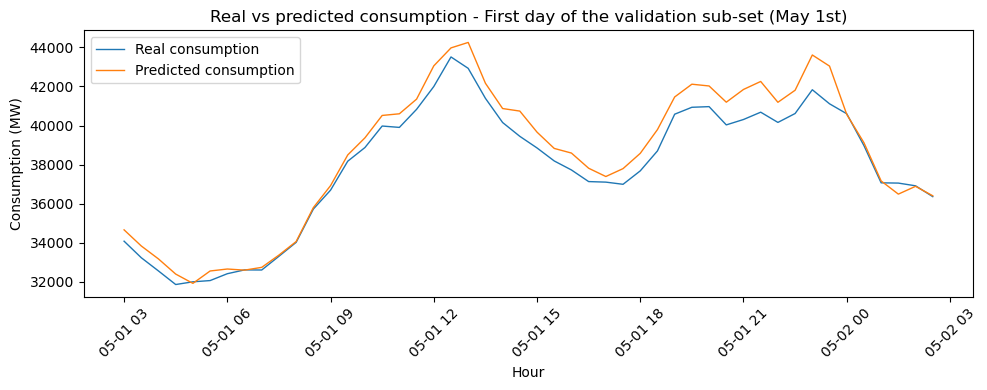

In [81]:
## Temporal visualization ##

dt = pd.to_datetime(
    valid_fe_clean.index.strftime("%Y-%m-%d") + " " + valid_fe_clean["Heures"],
    format="%Y-%m-%d %H:%M"
)
valid_fe = valid_fe_clean.copy()
valid_fe.index = dt
pred_valid = cons_pred_valid.copy()
pred_valid.index = dt

n = 48
x = valid_fe.index[:n]
y_real = valid_fe["Consommation"].iloc[:n]
y_pred = pred_valid.iloc[:n]

plt.figure(figsize=(10, 4))
plt.plot(x, y_real, label = "Real consumption", linewidth = 1)
plt.plot(x, y_pred, label = "Predicted consumption", linewidth = 1)
plt.xlabel("Hour")
plt.ylabel("Consumption (MW)")
plt.title("Real vs predicted consumption - First day of the validation sub-set (May 1st)")
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

**Analyse** :

* La courbe du modèle colle bien au cycle de la journée.
* On observe la sur-prévision identifiée précédement.
* Le modèle semble lisser légèrement certaines variations.

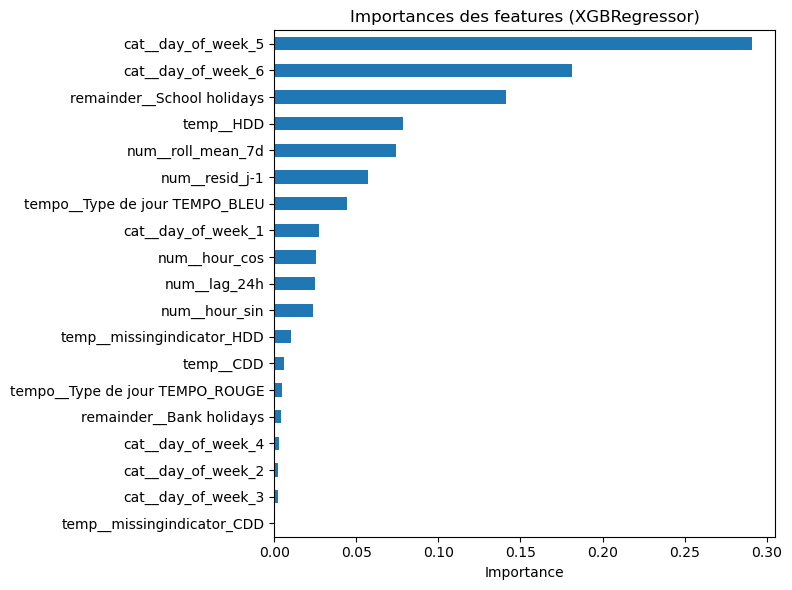

In [82]:
## Feature importance ##

feature_names = prep.get_feature_names_out()

importances = xgb.feature_importances_

fi = pd.Series(importances, index=feature_names).sort_values(ascending = False)

plt.figure(figsize = (8, 6))
fi.plot(kind = 'barh')
plt.gca().invert_yaxis()  # to have the most important one at the top
plt.title("Importances des features (XGBRegressor)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

**Analyse** :

**Les variables de jour de semaine dominent** :

* Les deux plus grosses importances tombent sur *cat__day_of_week_5* et *cat__day_of_week_6*, qui correspondent respectivement aux samedis et dimanches (avec un encodage où lundi = 0). Le modèle capte avant tout la baisse de conso le week-end.
* *cat__day_of_week_1* (mardi) est plus bas que samedi et dimanche, mais aussi beaucoup plus haut que mercredi, jeudi et vendredi. Pourquoi mardi ? Vu que *cat__day_of_week_1* traduit la différence entre mardi et lundi (qui est la catégorie de référence) il est probable qu'on observe ici le rebond d'activité du au retour de congés du week-end, au retour du télétravail le lundi, ou plus largement au démarrage de la semaine.

**Vacances scolaires vs jours fériés** : 

* L’indicateur *remainder__School holidays* se classe troisième, montrant que les vacances scolaires ont un impact significatif (baisse de la demande).

* À l’inverse, *remainder__Bank holidays* (jours fériés) pèse très peu : même si on a vu dans l'EDA que la consommation baissait beaucoup durant les jours fériés, l’effet ponctuel semble beaucoup moins structurant qu’une semaine de vacances entière.

**Météo** :

* *temp__HDD* (Heating Degree Days) pèse beaucoup plus lourd que *temp__CDD* (Cooling Degree Days), ce qui est cohérent pour le climat tempéré de la France, où le chauffage est un moteur de demande plus stable que la climatisation.
* *temp_missingindicator_HDD* et *temp_missingindicator_CDD* n’apportent vraiment peu d’information additionnelle.
  
**Les lags** :

* *num__roll_mean_7d* pèse assez lourd et arrive juste après *temp__HDD*, ce qui montre que la tendance de consommation hebdo est structurante.

* *num__resid_j-1* (erreur de la prévision naïve d’hier) est aussi importante, pas beaucoup moins que *num__roll_mean_7d*, ce qui montre que le modèle s’appuie autant sur la tendance hebdo que sur la performance de la prévision naïve précédente.

* *num__lag_24h* et les composantes cycliques *hour_sin* et *hour_cos* ont un rôle plus modéré mais non négligeable. Leur information est peut-être en partie redondante avec le rolling ?

* C'était une plutôt bonne idée de créer ces features !

**TEMPO** :

* *TEMPO BLEU* (jours les moins chers) a une importance modérée mais non négligeable, du au fait qu'il représente les jours majoritaires et homogènes d’un point de vue conso.
* *TEMPO ROUGE* (jours les plus chers) a une importance très faible, probablement du au fait qu'il n'y a qu'une poignée de jours ROUGE dans le dataset, mais aussi probablement qu'il représente des jours plus chaotiques, qui coincident souvent avec des pointes de froid extrême et d’autres facteurs moins facilement prévisible.

In [115]:
## Prediction on day N at noon the total consumption of day N+1 ##

last_date = test_fe_clean.index.max()

row_midday = test_fe_clean.loc[
    (test_fe_clean.index == last_date) &
    (test_fe_clean['Heures'] == '12:00')
]


X_last_resid = row_midday.drop(columns = [
    'Heures', 'Consommation', 'Prévision J', 'Prévision J-1',
    'Avg_temp_min','Avg_temp_max','Avg_temp_mean'
])

X_last_pre = pipe.named_steps['prep'].transform(X_last_resid)
resid_pred = pipe.named_steps['model'].predict(X_last_pre)[0]

prevision_j = row_midday['Prévision J'].iloc[0]

cons_pred_next = prevision_j + resid_pred

next_date = last_date + pd.Timedelta(days=1)
print(f"Consumption prediction for {next_date.date()} at noon : {cons_pred_next:.1f} MW")


Consumption prediction for 2025-04-30 at noon : 46437.9 MW
